### Necessary Packages

In [1]:
import os
import dotenv
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import sys
import pandas as pd
import warnings
from tqdm.notebook import tqdm
sys.path.append('../..')

In [2]:
warnings.filterwarnings("ignore")

### Global

In [4]:
DATA_DIR = dotenv.get_key(dotenv.find_dotenv(), "ROI_FOLDER")
TARGET_DIR = dotenv.get_key(dotenv.find_dotenv(), "PATCHES_FOLDER")
FOLDERS = ['0_N', '1_PB', '2_UDH', '3_FEA', '4_ADH', '5_DCIS', '6_IC']
SPLITS = ['val' , 'train', 'test']
PATCH_SIZE = 224

### Utiliy Functions

In [5]:
def load_image(infilename) :
    img = Image.open(infilename)
    img.load()
    return img

In [6]:
def split_image_into_patches(image, patch_size):
    width, height = image.size
    patches = []
    for y in range(0, height, patch_size):
        for x in range(0, width, patch_size):
            box = (x, y, x + patch_size, y + patch_size)
            patch = image.crop(box)
            patches.append(patch)
    return patches
    

In [7]:
def get_new_dimensions(width : int, height : int, patch_height : int = PATCH_SIZE, patch_width : int = PATCH_SIZE):
    width_coef = int(np.round(width / patch_width).astype(np.int32))
    height_coef = int(np.round(height / patch_height).astype(np.int32))

    new_width = width_coef * patch_width
    new_height = height_coef * patch_height

    return new_width, new_height

In [8]:
test = load_image(os.path.join(DATA_DIR, "test", "0_N", "BRACS_264_N_11.png"))
width, height = test.size
new_width, new_height = get_new_dimensions(width, height, PATCH_SIZE, PATCH_SIZE)
print(new_width, new_height)
test = test.resize((new_width, new_height))
patches = split_image_into_patches(test, PATCH_SIZE)
print(len(patches))

1792 1344
48


### Test on one image

In [9]:
def plot_patches(patches):
    num_patches = len(patches)
    num_cols = 5  # Number of columns in the grid
    num_rows = (num_patches + num_cols - 1) // num_cols  # Calculate number of rows required
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 12))

    for i, ax in enumerate(axes.flat):
        if i < num_patches:
            ax.imshow(patches[i])
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

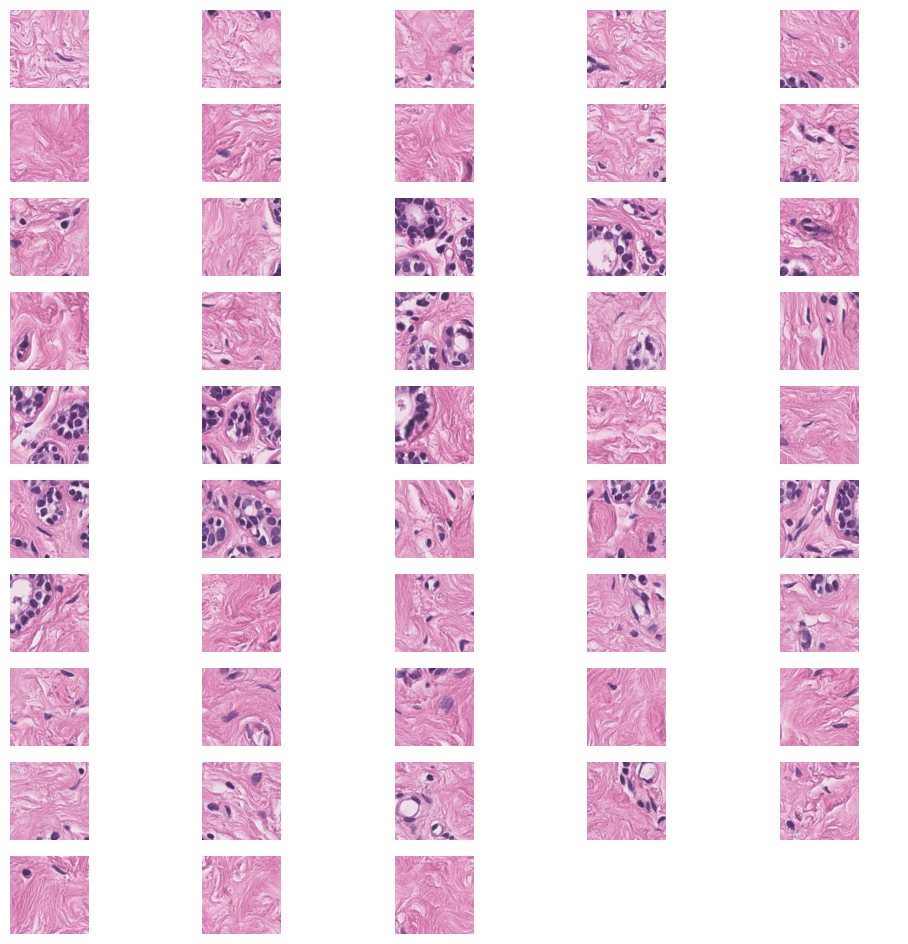

In [10]:
plot_patches(patches)

### Patching

In [11]:
def patch(
    src_dir : str, 
    dst_dir : str, 
    patch_size : int,
    splits : list[str],
    folders : list[str]
) -> pd.DataFrame:

    df = pd.DataFrame(columns=['patch', 'label', 'split', 'original image path', 'height', 'width'])
    
    for split in splits:

        for folder in folders:

            print(f"Processing {split} {folder}")

            folder_path = os.path.join(src_dir, split, folder)
            target_folder_path = os.path.join(dst_dir, split, folder)

            os.makedirs(target_folder_path, exist_ok=True)

            t_object = tqdm(os.listdir(folder_path))

            for file in t_object:

                t_object.set_description(f"File = {file}")
                
                img = load_image(os.path.join(folder_path, file))
                width, height = img.size
                new_width, new_height = get_new_dimensions(width, height, patch_size, patch_size)
                img = img.resize((new_width, new_height))
                patches = split_image_into_patches(img, patch_size)

                for i, patch in enumerate(patches):
                    
                    patch.save(os.path.join(target_folder_path, f"{file.split('.')[0]}_{i}.png"))

                    row = pd.DataFrame({
                        'patch': [f"{file.split('.')[0]}_{i}.png"], 
                        'label': [folder], 
                        'split': [split], 
                        'original image path': os.path.join(split,folder,file), 
                        'height': [patch.size[1]], 
                        'width': [patch.size[0]]
                    })
                    
                    df = pd.concat([df, row])

    return df

In [12]:
df = patch(DATA_DIR, TARGET_DIR, PATCH_SIZE, SPLITS, FOLDERS)

Processing val 0_N


  0%|          | 0/46 [00:00<?, ?it/s]

Processing val 1_PB


  0%|          | 0/43 [00:00<?, ?it/s]

Processing val 2_UDH


  0%|          | 0/46 [00:00<?, ?it/s]

Processing val 3_FEA


  0%|          | 0/49 [00:00<?, ?it/s]

Processing val 4_ADH


  0%|          | 0/41 [00:00<?, ?it/s]

Processing val 5_DCIS


  0%|          | 0/40 [00:00<?, ?it/s]

Processing val 6_IC


  0%|          | 0/47 [00:00<?, ?it/s]

Processing train 0_N


  0%|          | 0/357 [00:00<?, ?it/s]

Processing train 1_PB


  0%|          | 0/714 [00:00<?, ?it/s]

Processing train 2_UDH


  0%|          | 0/389 [00:00<?, ?it/s]

Processing train 3_FEA


  0%|          | 0/624 [00:00<?, ?it/s]

Processing train 4_ADH


  0%|          | 0/387 [00:00<?, ?it/s]

Processing train 5_DCIS


  0%|          | 0/665 [00:00<?, ?it/s]

Processing train 6_IC


  0%|          | 0/521 [00:00<?, ?it/s]

Processing test 0_N


  0%|          | 0/81 [00:00<?, ?it/s]

Processing test 1_PB


  0%|          | 0/79 [00:00<?, ?it/s]

Processing test 2_UDH


  0%|          | 0/82 [00:00<?, ?it/s]

Processing test 3_FEA


  0%|          | 0/83 [00:00<?, ?it/s]

Processing test 4_ADH


  0%|          | 0/79 [00:00<?, ?it/s]

Processing test 5_DCIS


  0%|          | 0/85 [00:00<?, ?it/s]

Processing test 6_IC


  0%|          | 0/81 [00:00<?, ?it/s]

In [13]:
df.head()

,patch,label,split,original image path,height,width
0,BRACS_265_N_4_0.png,0_N,val,val/0_N/BRACS_265_N_4.png,224,224
0,BRACS_265_N_4_1.png,0_N,val,val/0_N/BRACS_265_N_4.png,224,224
0,BRACS_265_N_4_2.png,0_N,val,val/0_N/BRACS_265_N_4.png,224,224
0,BRACS_265_N_4_3.png,0_N,val,val/0_N/BRACS_265_N_4.png,224,224
0,BRACS_1584_N_2_0.png,0_N,val,val/0_N/BRACS_1584_N_2.png,224,224


In [14]:
df.shape

(404424, 6)